# Step 1: Implement the vector median filter for colour images.

Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes.   

The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.

Your function should accept images of dtype `uint8` or `float`.    It is easiest if you work with the image as data type `float`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float`, construct the output image also as type `float` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [1]:
def vector_median(I, radius):
    convert_output_to_ubyte = False

    # Pre-allocate the output array
    if I.dtype == np.uint8:
        I = util.img_as_float(I)
        convert_output_to_ubyte = True

    VMF = np.zeros_like(I)

    # Pad the input array
    I = np.pad(I, ((radius, radius), (radius, radius), (0, 0)), 'edge')
    wso = 2 * radius

    for r in range(VMF.shape[0]):
        for c in range(VMF.shape[1]):
            # extract vectors from image patch
            vectors = I[r:r + wso + 1, c:c + wso + 1, :]
            vectors = np.reshape(vectors, (pow(2 * radius + 1, 2), 3))
            
            # np. broadcast_to() is just a lower-level version of np.tile().  I was trying to
            # squeeze out more speed.  Using tile() instead is fine.
            Y = np.broadcast_to(vectors[:, :, np.newaxis],
                                            (vectors.shape[0], vectors.shape[1], vectors.shape[0]))
            X = np.transpose(np.expand_dims(vectors, axis=2), (2, 1, 0))
            X = np.broadcast_to(X, (vectors.shape[0], X.shape[1], X.shape[2]))
            
            # Get the manhattan distances.
            sqdif = np.abs(Y - X)
            
            # Sum them over the first two dimensions.
            vsums = np.sum(sqdif, axis=(0,1), keepdims=True)

            # Get the index of the minimum sum of distances.
            idx = np.argmin(vsums)
            
            # Copy the idx-th color in the neighbourhood to the output image.
            VMF[r, c, :] = vectors[idx, :]

    if convert_output_to_ubyte:
        VMF = util.img_as_ubyte(VMF)
    return VMF

# Step 2: Establish a Baseline

Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list. 

Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.  

The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skimage.measure.compare_psnr()` and `skimage.measure.compare_ssim()`.  You'll need the `multichannel=true` argument for `compare_ssim()`.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._

_Hint: To median filter a colour image, you can filter each channel separately._

In [17]:
import skimage.io as io
import os as os
import skimage.filters as filt
import skimage.measure as meas
import skimage.util as util
import numpy as np

%matplotlib inline

PSNR_noisy = []
SSIM_noisy = []
PSNR_median_filtered = []
SSIM_median_filtered = []

# For every file in the noisy images folder...
for root, dirs, files in os.walk('asn1/solution/images/noisy-test'):
    for filename in files:
        
        # construct the full filename
        fname = os.path.join(root, filename)
        if filename == '.DS_Store':
            continue
        
        # Process image file 'fname' here.  Start by loading the images
        noisy = io.imread(fname)
        noiseless = io.imread(os.path.join('asn1/solution/images/noiseless', filename))
        
        # Median filter the image, one channel at a time.
        median_filtered = vector_median(noisy, 1)
                
        # Compute PSNR and SSIM for the original noisy image, append to list.
        PSNR_noisy.append(meas.compare_psnr(noiseless, noisy))
        SSIM_noisy.append(meas.compare_ssim(noiseless, noisy, multichannel=True))
        
        # Compute PSNR and SSIM for the median filtered image, append to list.
        PSNR_median_filtered.append(meas.compare_psnr(noiseless, median_filtered))
        SSIM_median_filtered.append(meas.compare_ssim(noiseless, median_filtered, multichannel=True))

/Users/mark/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Step 2: Compute average baseline metrics.

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

(0, 1)

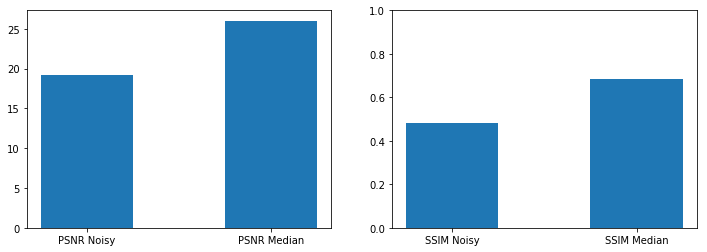

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get the averages of each list, above.
PSNR_noisy_average = np.mean(np.array(PSNR_noisy))
SSIM_noisy_average = np.mean(np.array(SSIM_noisy))
PSNR_median_filtered_average = np.mean(np.array(PSNR_median_filtered))
SSIM_median_filtered_average = np.mean(np.array(SSIM_median_filtered))

# Slap them into an array.
data = np.array([PSNR_noisy_average,  PSNR_median_filtered_average, SSIM_noisy_average,
                 SSIM_median_filtered_average])

# Plot as a bar graph.
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
bar_corners = np.arange(0.25, 2, 1)
plt.bar(bar_corners, data[0:2], width=.5)
plt.xticks(bar_corners, ['PSNR Noisy', 'PSNR Median'])

plt.subplot(122)
plt.bar(bar_corners, data[2:], width=.5)
plt.xticks(bar_corners, ['SSIM Noisy', 'SSIM Median'])
plt.ylim((0,1))


# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


/Users/mark/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(0, 1)

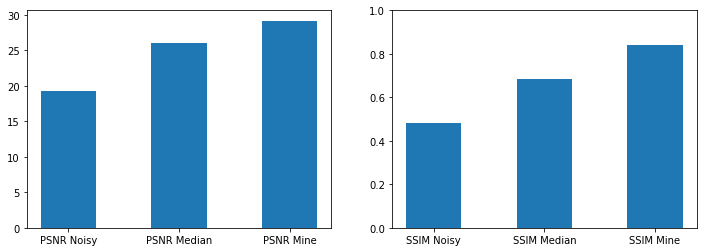

In [26]:
import skimage.color as color
import skimage.restoration as rest

PSNR_mine = []
SSIM_mine = []

# for each noisy image...
for root, dirs, files in os.walk('asn1/solution/images/noisy-test'):
    for filename in files:
        fname = os.path.join(root, filename)
        if filename == '.DS_Store':
            continue
            
        # median filter it
        noisy = io.imread(fname)
        median_filtered = vector_median(noisy, 1)  
        noiseless = io.imread(os.path.join('asn1/solution/images/noiseless', filename))            
            
        # Find where the luminance of the filtered image differs a LOT from the noisy image.
        diff = np.abs(color.rgb2gray(noisy)-color.rgb2gray(median_filtered))
           
        x,y = np.where(diff > .45)
        
        denoised = noisy.copy()
        denoised[x,y,:] = median_filtered[x,y,:]        
        denoised = util.img_as_ubyte(rest.denoise_tv_bregman(denoised, 15))
  
        
        # Compute PSNR and SSIM for the original noisy image, append to list.
        PSNR_mine.append(meas.compare_psnr(noiseless, denoised))
        SSIM_mine.append(meas.compare_ssim(noiseless, denoised, multichannel=True))
        
        io.imsave(os.path.join('asn1', 'solution', 'images', 'denoised',filename), denoised)
        
PSNR_mine_avg = np.mean(np.array(PSNR_mine))
SSIM_mine_avg = np.mean(np.array(SSIM_mine))

# Slap them into an array.
data = np.array([PSNR_noisy_average, PSNR_median_filtered_average,  PSNR_mine_avg, 
                 SSIM_noisy_average, SSIM_median_filtered_average, SSIM_mine_avg])

# Plot as a bar graph.
plt.subplots(1,2, figsize=(12,4))
plt.subplot(121)
bar_corners = np.arange(0.25, 3, 1)
plt.bar(bar_corners, data[0:3], width=.5)
plt.xticks(bar_corners, ['PSNR Noisy', 'PSNR Median', 'PSNR Mine'])

plt.subplot(122)
plt.bar(bar_corners, data[3:], width=.5)
plt.xticks(bar_corners, ['SSIM Noisy', 'SSIM Median', 'SSIM Mine'])
plt.ylim((0,1))
